In [67]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

In [68]:
import torch
print(torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
# print("CUDA Device Name:", torch.cuda.get_device_name(0))

1.7.1+cu110
CUDA Available: True
Number of GPUs available: 1


In [ ]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='IMDB-BINARY',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=5,
    hidden_graphs=16,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=5,
    max_step=2,
    normalize=False,
    num_samples=4
)

In [70]:
device = torch.device("cpu")

In [71]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=42)
it = 0
accs = list()

In [72]:
# THE MODEL
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.metrics import roc_auc_score, average_precision_score
import scipy.sparse as sp
import numpy as np
import os
import time
import networkx as nx
from input_data import load_data
from preprocessing import preprocess_graph
import vgae_model
from types import SimpleNamespace
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import random

vgae_args = SimpleNamespace(
    ### CONFIGS ###
    model = 'VGAE',
    input_dim = args.size_hidden_graphs, 
    hidden1_dim = 4,
    hidden2_dim = 3,
    use_feature = True,
    num_epoch = 25,
    learning_rate = 0.01
)

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device

        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.adj_hidden_tree = None
        self.adj_hidden_tree_norm = None
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.hidden_dim = hidden_dim
        self.features_hidden_tree = None
        self.input_dim = input_dim
        self.penultimate_dim = penultimate_dim

        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()
        
        self.metagraph = None
        self.cluster_labels = None
        self.vgae_graphs = None


    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator, y=None):
        if self.training:
            unique, counts = torch.unique(graph_indicator, return_counts=True)
            n_graphs = unique.size(0)
            n_nodes = features.size(0)

            if self.normalize:
                norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
            
            adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
            idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
            adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
            adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
            adj_hidden_norm[adj_hidden_norm > 0] = 1

            x = self.sigmoid(self.fc(features))
            z = self.features_hidden
            zx = torch.einsum("abc,dc->abd", (z, x))
            
            out = list()
            for i in range(self.max_step):
                if i == 0:
                    eye = torch.eye(self.size_hidden_graphs, device=self.device)
                    eye = eye.repeat(self.hidden_graphs, 1, 1)              
                    o = torch.einsum("abc,acd->abd", (eye, z))
                    t = torch.einsum("abc,dc->abd", (o, x))
                else:
                    x = torch.spmm(adj, x)
                    z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                    t = torch.einsum("abc,dc->abd", (z, x))
                t = self.dropout(t)
                t = torch.mul(zx, t)
                t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                t = torch.sum(t, dim=1)
                t = torch.transpose(t, 0, 1)
                if self.normalize:
                    t /= norm
                out.append(t)
                
            out = torch.cat(out, dim=1)
            out = self.bn(out)
            out = self.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            return F.log_softmax(out, dim=1)
        else:
            num_samples = args.num_samples
            adj_hidden_vgae, vgae_features = self.run_vgae(num_samples)
            unique, counts = torch.unique(graph_indicator, return_counts=True)
            n_graphs = unique.size(0)
            n_nodes = features.size(0)

            if self.normalize:
                norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)


            adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
            idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
            adj_hidden_norm[:,idx[0],idx[1]] = self.relu(adj_hidden_vgae)
            adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
            x = self.sigmoid(self.fc(features))
            z = self.features_hidden
            zx = torch.einsum("abc,dc->abd", (z, x))
            
            out = list()
            for i in range(self.max_step):
                if i == 0:
                    eye = torch.eye(self.size_hidden_graphs, device=self.device)
                    eye = eye.repeat(self.hidden_graphs, 1, 1)              
                    o = torch.einsum("abc,acd->abd", (eye, z))
                    t = torch.einsum("abc,dc->abd", (o, x))
                else:
                    x = torch.spmm(adj, x)
                    z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                    t = torch.einsum("abc,dc->abd", (z, x))
                t = self.dropout(t)
                t = torch.mul(zx, t)
                t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                t = torch.sum(t, dim=1)
                t = torch.transpose(t, 0, 1)
                if self.normalize:
                    t /= norm
                out.append(t)
                
            out = torch.cat(out, dim=1)
            out = self.bn(out)
            out = self.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            return F.log_softmax(out, dim=1)
        

    
    def get_hidden_graphs_adjacency_list(self):
        """Converts the upper-triangular adjacency data to adjacency lists."""
        adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
        # Convert each hidden graph's adjacency matrix to an adjacency list
        adjacency_lists = []
        for i in range(self.hidden_graphs):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        
        return adjacency_lists
    


# VGAE METHODS
    def sparse_to_tuple(self, sparse_mx):
        if not sp.isspmatrix_coo(sparse_mx):
            sparse_mx = sparse_mx.tocoo()
        coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
        values = sparse_mx.data
        shape = sparse_mx.shape
        return coords, values, shape
    def mask_test_edges(self, adj):
        adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
        adj.eliminate_zeros()

        adj_triu = sp.triu(adj)
        adj_tuple = self.sparse_to_tuple(adj_triu)
        edges = adj_tuple[0]

        num_edges = edges.shape[0]
        if num_edges < 10:
            # print("Not enough edges for a split. Using all edges for training.")
            return edges, [], []  # Return all edges for training, no validation/test

        num_test = int(np.floor(num_edges / 10.))
        num_val = int(np.floor(num_edges / 20.))

        all_edge_idx = list(range(num_edges))
        np.random.shuffle(all_edge_idx)
        val_edge_idx = all_edge_idx[:num_val]
        test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]

        test_edges = edges[test_edge_idx] if test_edge_idx else []
        val_edges = edges[val_edge_idx] if val_edge_idx else []
        if test_edge_idx or val_edge_idx:
            train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)
        else:
            train_edges = edges

        return train_edges, val_edges, test_edges
    def get_acc(self, adj_rec, adj_label):
        labels_all = adj_label.to_dense().view(-1).long()
        preds_all = (adj_rec > 0.5).view(-1).long()
        accuracy = (preds_all == labels_all).sum().float() / labels_all.size(0)
        return accuracy
    
    def genMetaGraphs(self, graph_dist_adj_matrix):
        G = nx.from_numpy_array(graph_dist_adj_matrix)

        pos = nx.spring_layout(G)

        nx.draw_networkx_nodes(G, pos)

        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        plt.show()
    # NUM_SAMPLES = NUM_CLUSTERS
    def getSamples(self, num_samples):
        adjacency_lists = self.get_hidden_graphs_adjacency_list()
        # for graph_id, adj_list in enumerate(adjacency_lists):
            # if len(adj_list) != 5:
            #     print("FIRST ONE NOT GOOD")
            #     raise ValueError(f"Graph {graph_id} does not have exactly 5 nodes. It has {len(adj_list)} nodes.")
        graphs = []

        # Draw the adjacency list as a graph using NetworkX and Matplotlib
        for i, adj_list in enumerate(adjacency_lists):
            G = nx.Graph()  # Create a new graph
            # Add edges to the graph based on the adjacency list
            for node, neighbors in adj_list.items():
                G.add_node(node)
                for neighbor in neighbors:
                    G.add_edge(node, neighbor)

            # if len(G.nodes) != 5:
            #     raise ValueError(f"Graph {i} does not have exactly 5 nodes. It has {len(G.nodes)} nodes.")

            # for j, graph in enumerate(graphs):
            #     if nx.is_isomorphic(graph, G):
            #         print("Graph", i, "is isomorphic to previous graph", j)
            graphs.append(G)

        #Edit distance
        graph_dist_adj_matrix = np.zeros(shape=(len(graphs),len(graphs)))
        
        for i, graph_1 in enumerate(graphs):
            for j, graph_2 in enumerate(graphs):
                if i == j:
                    continue

                graph_edit_distance = nx.graph_edit_distance(graph_1, graph_2)
                # print('Edit distance between graph', i, ' and graph', j, ':', graph_edit_distance)
                graph_dist_adj_matrix[i, j] = graph_edit_distance
        
        graph_dist_adj_matrix_rounded = np.round(graph_dist_adj_matrix, 3)

        G = nx.from_numpy_array(graph_dist_adj_matrix_rounded)
        self.metagraph = G
        # pos = nx.spring_layout(G)

        # nx.draw_networkx_nodes(G, pos)

        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edges(G, pos)
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

        # plt.show()
        # Perform clustering
        # use metagraph adjacency matrix as node features
        node_features = graph_dist_adj_matrix

        # apply PCA for dimensionality reduction
        pca = PCA(n_components=2)  # Reduce to 2 components for visualization
        reduced_features = pca.fit_transform(node_features)
        
        # apply clustering
        num_clusters = num_samples
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(reduced_features)

        self.cluster_labels = cluster_labels
        # visualize metagraph with cluster labels
        # pos = nx.spring_layout(G)  # Spring layout for visualization
        # nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
        # nx.draw_networkx_edges(G, pos, alpha=0.5)

        # # Draw edge labels (weights)
        # weights = nx.get_edge_attributes(G, "weight")
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8)


        # # Add labels (optional)
        # nx.draw_networkx_labels(G, pos, font_size=10)
        # plt.title("Clustering of Meta-Graph Nodes")
        # plt.show()
        
        # Step 1: Group graph indices by cluster labels
        cluster_to_graphs = {i: [] for i in range(num_clusters)}
        for graph_idx, cluster_id in enumerate(cluster_labels):
            cluster_to_graphs[cluster_id].append(graph_idx)
            graph = graphs[graph_idx]  # Get the graph corresponding to the index
            # Check  if the graph has exactly 5 nodes
            # if len(graph.nodes) != 5:
            #     raise ValueError(f"Graph {graph_idx} in cluster {cluster_id} does not have exactly 5 nodes. It has {len(graph.nodes)} nodes.")
        # print(cluster_labels)
        # Step 2: Sample one graph per cluster
        sampled_graphs = {}
        for cluster_id, graph_indices in cluster_to_graphs.items():
            if graph_indices:
                sampled_graph = random.choice(graph_indices)  # Randomly sample one graph
                sampled_graphs[cluster_id] = graphs[sampled_graph]  # Retrieve the actual graph
        # print(sampled_graphs)
        # Step 3: (Optional) Visualize sampled graphs
        # for cluster_id, graph in sampled_graphs.items():
        #     plt.figure(figsize=(6, 6))
        #     nx.draw(graph, with_labels=True, node_color='skyblue', node_size=500, font_size=10)
        #     plt.title(f"Graph Sampled from Cluster {cluster_id}")
        #     plt.show()

        # Step 4: Represent sampled graphs as adjacency matrices
        sampled_adj_matrices = {}
        for cluster_id, graph in sampled_graphs.items():
            if graph:
            # Convert the graph to an adjacency matrix
                adj_matrix = nx.adjacency_matrix(graph).toarray()  # Convert sparse matrix to dense
                sampled_adj_matrices[cluster_id] = adj_matrix

        return sampled_adj_matrices

    def run_vgae(self, num_samples):
        
        adjacency_lists = self.getSamples(num_samples)
        
        # Train on CPU (hide GPU) due to memory constraints
        # os.environ['CUDA_VISIBLE_DEVICES'] = ""
        upper_tri_values_list = [None] * self.hidden_graphs
        adj_num = 0

        features_list = []
        self.vgae_graphs = []
        for adj in adjacency_lists:
            adj = adjacency_lists[0]
            # Check if adj is a PyTorch tensor and convert it to scipy sparse matrix
            if isinstance(adj, torch.Tensor):
                adj = adj.cpu().numpy()  # Convert tensor to numpy array
                adj = sp.coo_matrix(adj)  # Convert numpy array to sparse matrix

            # Ensure adjacency matrix is sparse (in case it's not already)
            if not sp.isspmatrix(adj):
                adj = sp.coo_matrix(adj)

            # Generate feature matrix (identity matrix in sparse format)
            num_nodes = adj.shape[0]
            features = sp.identity(num_nodes).tolil()

            # Store original adjacency matrix (without diagonal entries)
            adj_orig = adj
            adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
            adj_orig.eliminate_zeros()


            # Mask the edges (train/validation/test split)
            train_edges, val_edges, test_edges = self.mask_test_edges(adj)

            # Using the training adjacency matrix
            adj_train = adj  # Assuming adj_train is returned or defined within mask_test_edges
            adj_norm = preprocess_graph(adj)
            num_nodes = adj.shape[0]

            features = self.sparse_to_tuple(features.tocoo())
            num_features = features[2][1]
            features_nonzero = features[1].shape[0]

            # Create Model
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)


            adj_label = adj_train + sp.eye(adj_train.shape[0])
            adj_label = self.sparse_to_tuple(adj_label)



            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                                        torch.FloatTensor(adj_norm[1]), 
                                        torch.Size(adj_norm[2]))
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                                        torch.FloatTensor(adj_label[1]), 
                                        torch.Size(adj_label[2]))
            features = torch.sparse.FloatTensor(torch.LongTensor(features[0].T), 
                                        torch.FloatTensor(features[1]), 
                                        torch.Size(features[2]))

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0)) 
            weight_tensor[weight_mask] = pos_weight

            # init model and optimizer
            model = getattr(vgae_model,vgae_args.model)(adj_norm, vgae_args.input_dim, vgae_args.hidden1_dim, vgae_args.hidden2_dim) 
            optimizer = Adam(model.parameters(), lr=vgae_args.learning_rate)
            # Initialize VGAE model with the adjacency matrix
            adj_dense = torch.tensor(adj.toarray(), dtype=torch.float32)  # Ensure it's a tensor
            model = vgae_model.VGAE(adj_dense, vgae_args.input_dim, vgae_args.hidden1_dim, vgae_args.hidden2_dim)  # Make sure to pass the adjacency matrix during initialization
            # Training loop
            for epoch in range(vgae_args.num_epoch):
                t = time.time()

                # Pass the features to the model
                A_pred = model(features)
                
                optimizer.zero_grad()
                
                # Compute loss
                loss = log_lik = norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight=weight_tensor)
                
                if vgae_args.model == 'VGAE':
                    # KL divergence regularization
                    kl_divergence = 0.5 / A_pred.size(0) * (1 + 2 * model.logstd - model.mean**2 - torch.exp(model.logstd)**2).sum(1).mean()
                    loss -= kl_divergence

                # Backpropagate and optimize
                loss.backward()
                optimizer.step()

                # Compute train accuracy
                train_acc = self.get_acc(A_pred, adj_label)

            # Get latent embeddings (mean and log standard deviation)
            z_mean = model.mean
            z_log_std = model.logstd

            # Sample latent variables from the Gaussian distribution
            z_sampled = z_mean + torch.randn_like(z_log_std) * torch.exp(z_log_std)
            features = z_sampled
            features_list.append(features)

            # Decode the sampled latent variables to generate a new adjacency matrix
            new_adj_rec = torch.sigmoid(torch.matmul(z_sampled, z_sampled.t()))
            # Generate binary adjacency matrix (threshold the probabilities)
            threshold = 0.5  # Adjust the threshold as needed
            new_adj_binary = (new_adj_rec > threshold).float()
            G = nx.Graph()

            # Add edges based on the binary adjacency matrix
            num_nodes = new_adj_binary.shape[0]
            for i in range(num_nodes):
                for j in range(num_nodes):
                    if new_adj_binary[i, j] == 1:  # If there's an edge
                        G.add_edge(i, j)
            self.vgae_graphs.append(G)
            # Visualize the graph

            # convert to a tensor
            new_adj_sparse = sp.coo_matrix(new_adj_rec.detach().cpu().numpy())
            # Ensure adj is in sparse format after edge masking

            # Step 1: Convert sparse matrix to dense format
            new_adj_dense = new_adj_sparse.toarray()  # Convert sparse COO matrix to dense array

            # Step 2: Convert to PyTorch tensor
            new_adj_tensor = torch.tensor(new_adj_dense, dtype=torch.float32, device=self.device)

            # Step 3: Extract upper triangular values (excluding diagonal)
            idx = torch.triu_indices(new_adj_tensor.size(0), new_adj_tensor.size(1), offset=1)
            upper_tri_values = new_adj_tensor[idx[0], idx[1]]  # Extract upper triangular values

            iter = 0

            for cluster_label in self.cluster_labels:
                if(cluster_label == adj_num):
                    upper_tri_values_list[iter] = upper_tri_values
                iter += 1
            adj_num += 1

            # Step 4: Assign to self.adj_hidden
            # if upper_tri_values.shape[0] != self.adj_hidden.shape[1]:
            #     raise ValueError(f"Size mismatch: upper_tri_values has {upper_tri_values.shape} shape, but self.adj_hidden expects {self.adj_hidden.shape}.")
        for i, value in enumerate(upper_tri_values_list):
            if value is None:
                upper_tri_values_list[i] = torch.zeros(self.adj_hidden.shape[1])
        all_upper_tri_values = torch.stack(upper_tri_values_list, dim=0)  # Concatenate along the first dimension
        all_features = torch.stack(features_list, dim=0)  # Concatenate along the first dimension
        return all_upper_tri_values, all_features
    def get_vgae_graphs(self):
        return self.vgae_graphs
    def get_cluster_lables(self):
        return self.cluster_labels
    def get_meta_graph(self):
        return self.metagraph

In [73]:
for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output = model(adj, features, graph_indicator)
        loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))

        # Evaluate on validation set every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == args.epochs - 1:  # Always evaluate at the last epoch
            model.eval()
            val_loss = AverageMeter()
            val_acc = AverageMeter()

            for i in range(n_val_batches):
                output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
                val_loss.update(loss.item(), output.size(0))
                val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

            # Print validation results
            print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
                "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
                "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))

            # Remember best accuracy and save checkpoint
            is_best = val_acc.avg >= best_acc
            best_acc = max(val_acc.avg, best_acc)
            if is_best:
                early_stopping_counter = 0
                torch.save({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }, 'model_best.pth.tar')

        # Adjust learning rate
        scheduler.step()

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])


    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()

    print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))


Cross-val iter: 01 epoch: 010 train_loss= 0.06236 train_acc= 1.00000 val_loss= 0.00233 val_acc= 1.00000 time= 4.52911
Cross-val iter: 01 epoch: 020 train_loss= 0.02892 train_acc= 1.00000 val_loss= 0.00022 val_acc= 1.00000 time= 4.52304
Cross-val iter: 01 epoch: 025 train_loss= 0.03726 train_acc= 0.99753 val_loss= 0.00001 val_acc= 1.00000 time= 10.87734
Optimization finished!
Loading checkpoint!
test_loss= 0.00002 test_acc= 1.00000

avg_test_acc= 1.00000
Cross-val iter: 02 epoch: 010 train_loss= 0.01445 train_acc= 1.00000 val_loss= 0.00001 val_acc= 1.00000 time= 10.31482
Cross-val iter: 02 epoch: 020 train_loss= 0.00990 train_acc= 0.99506 val_loss= 0.00000 val_acc= 1.00000 time= 10.70547
Cross-val iter: 02 epoch: 025 train_loss= 0.01124 train_acc= 1.00000 val_loss= 0.00000 val_acc= 1.00000 time= 9.94881
Optimization finished!
Loading checkpoint!
test_loss= 0.00001 test_acc= 1.00000

avg_test_acc= 1.00000
Cross-val iter: 03 epoch: 010 train_loss= 0.01275 train_acc= 0.99753 val_loss= 0.00

{0: array([0.127568, 0.566949, 0.550556, 1.      ]), 1: array([0.993248, 0.906157, 0.143936, 1.      ])}


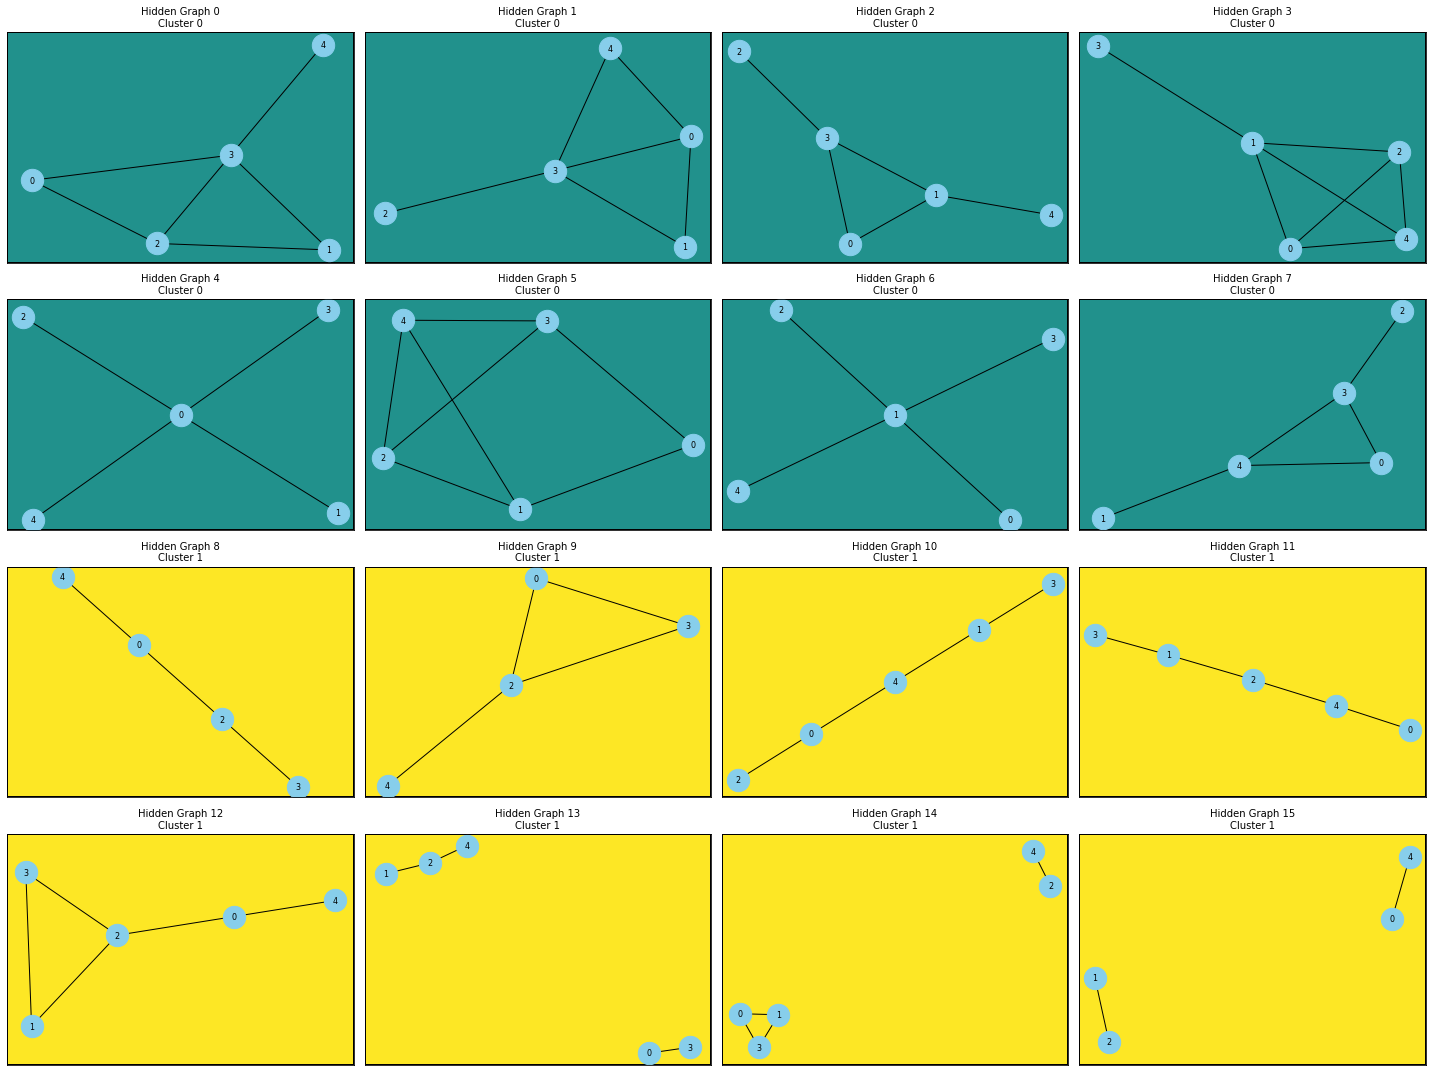

In [74]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors

# Assuming adjacency_lists is a list of dictionaries where each dictionary
# represents the adjacency list of a hidden graph.
adjacency_lists = model.get_hidden_graphs_adjacency_list()
cluster_labels = model.get_cluster_lables()

# Define a mapping from clusters to pale colors
# Ensure there are enough colors by generating more if needed
unique_clusters = sorted(set(cluster_labels))
colors = plt.cm.viridis(np.linspace(0.5, 1, len(unique_clusters)))  # Generates enough distinct colors

cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}
print(cluster_to_color)
# Pair the adjacency lists with their corresponding cluster labels and sort by cluster label
sorted_graphs = sorted(
    enumerate(adjacency_lists), 
    key=lambda x: cluster_labels[x[0]]
)
sorted_adjacency_lists = [adjacency_lists[i] for i, _ in sorted_graphs]
sorted_cluster_labels = [cluster_labels[i] for i, _ in sorted_graphs]

# Number of graphs
num_graphs = len(sorted_adjacency_lists)

# Determine grid size for displaying graphs (e.g., 4x4 for 16 graphs)
cols = 4  # Number of columns in the grid
rows = (num_graphs + cols - 1) // cols  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Set figure background to white
fig.patch.set_facecolor('white')

# Iterate through each hidden graph
for i, (adj_list, cluster_label) in enumerate(zip(sorted_adjacency_lists, sorted_cluster_labels)):
    G = nx.Graph()  # Create a new graph for each hidden graph
    
    # Add edges based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)
    
    # Get the current axis
    ax = axes[i]
    # Set subplot background to white
    ax.set_facecolor(cluster_to_color[cluster_label])
    
    # Compute positions for nodes
    pos = nx.spring_layout(G)
    
    # Draw edges with increased width and distinct color    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='black', width=1)

    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    # Adjust axis limits to ensure edges are visible
    x_vals, y_vals = zip(*pos.values())
    ax.set_xlim(min(x_vals) - 0.1, max(x_vals) + 0.1)
    ax.set_ylim(min(y_vals) - 0.1, max(y_vals) + 0.1)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a border around the subplot
    ax.add_patch(Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=2, edgecolor='black', facecolor='none'
    ))
    
    # Set the title
    ax.set_title(f"Hidden Graph {i}\nCluster {cluster_label}", fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


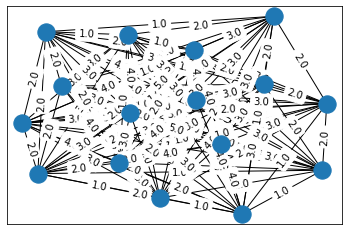

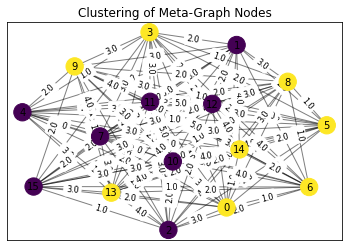

In [75]:
G = model.get_meta_graph()
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos)

labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

cluster_labels = model.get_cluster_lables()
# visualize metagraph with cluster labels
pos = nx.spring_layout(G)  # Spring layout for visualization
nx.draw_networkx_nodes(G, pos, node_color=cluster_labels, cmap='viridis', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Draw edge labels (weights)
weights = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights, font_size=8)


# Add labels (optional)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Clustering of Meta-Graph Nodes")
plt.show()

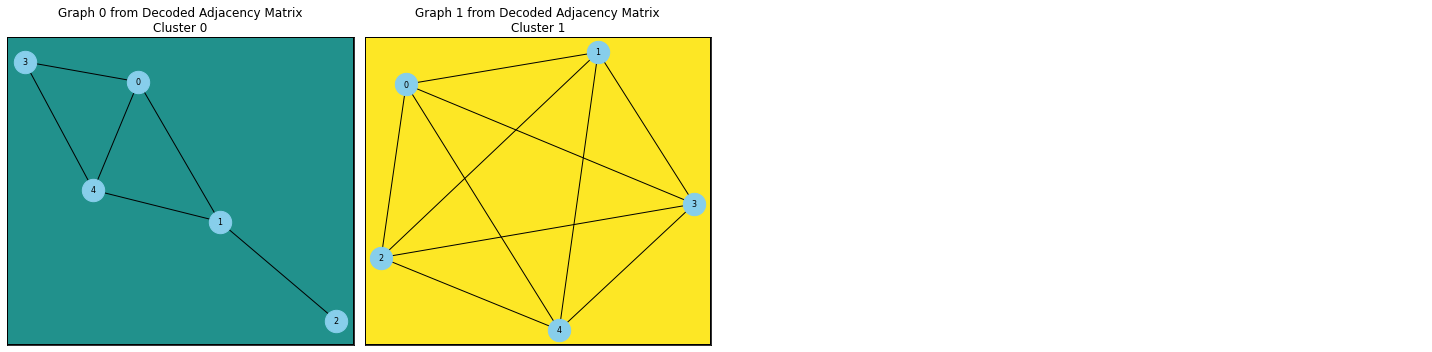

In [76]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np  # For np.linspace if not already imported

# Assuming vgae_graphs is a list of networkx graph objects
vgae_graphs = model.get_vgae_graphs()

# 0 1 2
#   2 1
# Generate a distinct set of colors for each graph
unique_clusters = sorted(set(range(len(vgae_graphs))))  # Using the index as the cluster label
colors = plt.cm.viridis(np.linspace(0.5, 1, len(unique_clusters)))  # Generates enough distinct colors
cluster_to_color = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Determine grid size for displaying graphs (e.g., 4x4 for 16 graphs)
cols = 4  # Number of columns in the grid
rows = (len(vgae_graphs) + cols - 1) // cols  # Calculate the required number of rows

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 5))
axes = axes.flatten()  # Flatten to make indexing easier

# Set figure background to white
fig.patch.set_facecolor('white')

# Iterate through each VGAE graph
for i, graph in enumerate(vgae_graphs):
    ax = axes[i]  # Get the current axis
    G = graph
    
    # Add edges based on the adjacency list
    cluster_label = i  # Cluster is the index of the graph
    
    # Set background color for the axis
    ax.set_facecolor(cluster_to_color[cluster_label])  # Set background color based on cluster
    pos = nx.spring_layout(G)
    
    # Draw edges with increased width and distinct color    
    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='skyblue', node_size=500)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='black', width=1)

    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    x_vals, y_vals = zip(*pos.values())
    ax.set_xlim(min(x_vals) - 0.1, max(x_vals) + 0.1)
    ax.set_ylim(min(y_vals) - 0.1, max(y_vals) + 0.1)
    # Draw the graph with default node and edge colors
    # nx.draw(
    #     graph, with_labels=True, node_color='skyblue', edge_color='gray',
    #     node_size=2000, font_size=10, ax=ax
    # )
    
    # Set the title for each subplot
    ax.set_title(f"Graph {i} from Decoded Adjacency Matrix\nCluster {cluster_label}")

    # Remove axis ticks for a cleaner view
    ax.set_xticks([]) 
    ax.set_yticks([])

    # Add a border around the subplot (optional)
    ax.add_patch(Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=2, edgecolor='black', facecolor='none'
    ))

# Hide any unused subplots (if there are fewer graphs than grid spaces)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
